# SafeNSound: Initial Log Scaled Mel-Spectrogram Development

## 1. Importing Libraries

In [ ]:
import os
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
import librosa as lb
# import librosa.display as ld
# import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
# import sounddevice as sd
from sklearn.model_selection import train_test_split

## 2. Datasets

In [3]:
EMERGENCY_PATH = os.path.join("..", "datasets", "emergency")
NORMAL_PATH = os.path.join("..", "datasets", "non-emergency")

def load_audio_files(directory, filename):
    if not os.path.exists(directory):
        raise FileNotFoundError(f"Directory {directory} does not exist.")

    if filename.endswith('.wav'):
        file_path = os.path.join(directory, filename)
        try:
            wav, sr = lb.load(file_path, sr=16000, mono=True)
            ##wav = tf.convert_to_tensor(wav, dtype=tf.float32)
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
    return wav, sr

#get audio real-time
## def record_audio(duration=5, sample_rate=16000):

## 3. Creating Mel Spectrogram & converting to Log Scale

In [4]:
def log_scaled_melspectrogram(audio, sample_rate, n_fft=1024, hop_length=512, n_mels=128, max_len=160):
    S = lb.feature.melspectrogram(y=audio, sr=sample_rate, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)

    if S.shape[1] < max_len:
        S = np.pad(S, ((0,0),(0, max_len - S.shape[1])), mode='constant')
    else:
        S = S[:, :max_len]

    S_dB = lb.power_to_db(S, ref=np.max)
    
    S_dB = S_dB[..., np.newaxis]
    
    return S_dB

## 4. Display Log-scaled Mel Spectrogram

In [ ]:
X = []
y = []
labels = {"emergency": 1, "non-emergency": 0}

# emergency_labels = {"crying sound", "door noise", "glassbreak sounds", "gunshots", "screaming sound"}
# non_emergency_labels = {"clap", "door sound", "fireworks", "object noise", "toilet noise"}

emergency_count = 0;
non_emergency_count = 0;

for label, idx in labels.items():
    main_path = EMERGENCY_PATH if label == "emergency" else NORMAL_PATH
    # subfolders =  emergency_labels if label == "emergency" else non_emergency_labels
            
    # for subfolder in subfolders:
    folder = f"{main_path}"

    if not os.path.exists(folder):
        print(f"Warning: Directory {folder} does not exist. Skipping...")
        continue

    for file in os.listdir(folder):
        if file.endswith(".wav"):
            try:
                wav, sr = load_audio_files(folder, file)
                lsms = log_scaled_melspectrogram(wav, sr)

                X.append(lsms)
                y.append(idx)

                if label == "emergency":
                    emergency_count += 1   
                else:
                    non_emergency_count += 1

            except Exception as e:
                print(f"Error processing {file} in {folder}: {e}")
                continue

X = np.array(X)
y = np.array(y)

y = to_categorical(y, num_classes=2)

## 5. Split

In [6]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

## 6. CNN

In [7]:
def build_cnn(input_shape, num_classes=2):
    model = models.Sequential([
        # Conv Block 1
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.3),

        # Conv Block 2
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.3),

        # Conv Block 3
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.3),

        # Flatten + Dense
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [8]:
input_shape = (X.shape[1], X.shape[2], X.shape[3])
print("Input shape:", input_shape)

model = build_cnn(input_shape, num_classes=2)
model.summary()

Input shape: (128, 160, 1)


c:\Users\Acer\Documents\GitHub\SafeNSound-An-IoT-Based-Distress-Signals-Detection-for-Semi-private-Rooms-using-Sound-Sensor\myenv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 160, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 160, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 80, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 80, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 40, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 40, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 40960)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     5,243,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,336,834 (20.36 MB)

 Trainable params: 5,336,386 (20.36 MB)

 Non-trainable params: 448 (1.75 KB)

## 7. Train

In [ ]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.5094 - loss: 14.1648 - val_accuracy: 0.2727 - val_loss: 33.6358
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 463ms/step - accuracy: 0.6981 - loss: 5.3834 - val_accuracy: 0.2727 - val_loss: 21.0418
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 407ms/step - accuracy: 0.7170 - loss: 6.0322 - val_accuracy: 0.2727 - val_loss: 139.3681
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 372ms/step - accuracy: 0.8491 - loss: 6.9242 - val_accuracy: 0.2727 - val_loss: 125.9810
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 369ms/step - accuracy: 0.8302 - loss: 2.8894 - val_accuracy: 0.2727 - val_loss: 44.7281
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 384ms/step - accuracy: 0.8302 - loss: 2.4145 - val_accuracy: 0.2727 - val_loss: 17.4707
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 332ms/step - accuracy: 0.8679 - loss: 1.1039 - val_accuracy: 0.2727 - val_loss: 15.2211
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 333ms/step - accuracy: 0.9245 - loss: 0.2231 - val_accuracy: 0.2727 - va

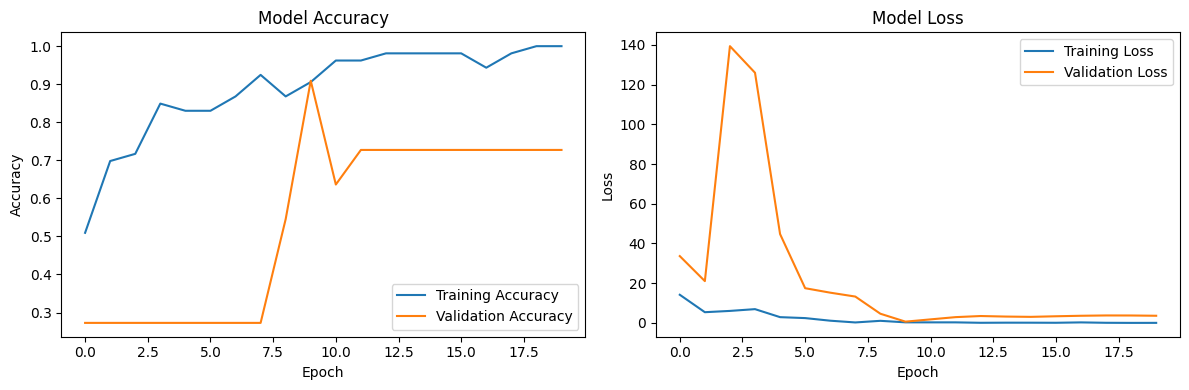

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.6667 - loss: 5.3604
Test accuracy: 0.6666666865348816


In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)